In [1]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

folder=r"J:\ctgroup\Edward\DATA\VMI\20250227\xe_2,5W"
files=[os.path.join(folder,f) for f in os.listdir(folder) if f.endswith('.mat')]
angles=[float(f.split("\\")[-1].split('_')[0]) for f in files]
angles,files=zip(*sorted(zip(angles,files)))
def load_file(file, smoothed=True, plot=False, py_shift=0, angle=0):
    data=scipy.io.loadmat(file,squeeze_me=True)
    px,py,pz=data['px'],data['py']+py_shift,data['pz']
    h=np.histogram(np.sqrt(px**2+py**2+pz**2),bins=500,range=(0,1))

    hist,edges=h[0],h[1]
    if smoothed:
        hist=scipy.signal.savgol_filter(hist,51,3)
    hist=hist/np.max(hist)

    peaks,properties=scipy.signal.find_peaks(hist,prominence=0.07)
    peak_widths=scipy.signal.peak_widths(hist,peaks,rel_height=0.2)[0]

    ring_vals=np.array([edges[int(peaks[i])] for i in range(len(peaks))])
    ring_widths=np.array([edges[int(peak_widths[i])] for i in range(len(peaks))])

    if plot:
        plt.figure(file)
        plt.plot(edges[:-1],hist)
        plt.plot(edges[peaks],hist[peaks],'x')
        [plt.plot([ring_vals[i]-ring_widths[i]*2,ring_vals[i]+ring_widths[i]*2],[0.5,0.5]) for i in range(len(ring_vals))]
    pr=np.sqrt(px**2+py**2+pz**2)
    masks=[(pr>ring_vals[i]-ring_widths[i]*2) & (pr<ring_vals[i]+ring_widths[i]*2) for i in range(len(ring_vals))]
    reasonable=np.abs(pz)<np.max(px)

    rings=[(px[masks[i]],py[masks[i]],pz[masks[i]]) for i in range(len(ring_vals))]
    px,pz= px*np.cos(angle)+pz*np.sin(angle),-px*np.sin(angle)+pz*np.cos(angle)
    return {
        'px':px[reasonable],
        'py':py[reasonable],
        'pz':pz[reasonable],
        'rings':rings,
        'ring_vals':ring_vals,
        'ring_widths':ring_widths
    }
data=[load_file(f,plot=False) for f in files]

In [2]:
n=256
thetav,phiv=np.linspace(0,np.pi,n),np.linspace(-np.pi,np.pi,n*2)
theta,phi=np.meshgrid(thetav,phiv)
dtheta,dphi=np.pi/n,2*np.pi/n/2
domega=np.sin(theta)*dtheta*dphi
lmax=19
Y={(l,m): scipy.special.sph_harm(m,l,phi,theta) for l in range(lmax+1) for m in range(-l,l+1)}
def get_beta(data,ring_number,Y,lmax,smoothing=3, symmetrize=False, n=1, k=0, angle=0, flip=False):
    ring=data['rings'][ring_number]
    px,py,pz=ring
    px,py,pz=px[k::n],py[k::n],pz[k::n]
    px,pz=px*np.cos(angle)+pz*np.sin(angle),-px*np.sin(angle)+pz*np.cos(angle)
    if flip:
        px,pz=-px,-pz
    if symmetrize:
        px,py,pz=np.vstack([px,-px]),np.vstack([py,py]),np.vstack([pz,-pz])
        px,py,pz=px.flatten(),py.flatten(),pz.flatten()

    pr=np.sqrt(px**2+py**2+pz**2)
    ptheta=np.arccos(py/pr)
    pphi=np.arctan2(px,pz)

    hist=np.histogram2d(pphi,ptheta,bins=(len(phiv),len(thetav)),density=True)[0]
    if smoothing>0:
        hist=scipy.ndimage.gaussian_filter(hist,smoothing)
    beta={(l,m): np.sum(hist*Y[(l,m)]*domega) for l in range(lmax+1) for m in range(-l,l+1)}
    return beta

betas={(angle,ring): get_beta(datum,ring,Y,lmax, angle=-angle, symmetrize=True) for angle,datum in zip(angles,data) for ring in range(len(datum['rings']))}

In [107]:
beta_df= pd.DataFrame({(angle,ring,l,m): betas[(angle,ring)][(l,m)] for angle,ring in betas.keys() for l in range(lmax+1) for m in range(-l,l+1)},index=[0]).T
beta_df.columns=['beta']
beta_df.index=pd.MultiIndex.from_tuples(beta_df.index, names=['angle','ring','l','m'])
beta_df["corr_angle"]=beta_df.index.get_level_values('angle')-1.7
beta_df["mag"]=np.abs(beta_df["beta"])
beta_df["mag2"]=np.abs(beta_df["beta"])**2
beta_df["phase"]=np.angle(beta_df["beta"])
beta_df["angle_off"]=beta_df["phase"]/beta_df.index.get_level_values('m')
beta_df["angle_off"]=beta_df["angle_off"].replace([np.inf, -np.inf], np.nan)
# beta_df.reset_index(inplace=True)
angle_list=beta_df.index.get_level_values('angle').unique()

chi2=pd.DataFrame()
for angle in angles:
    ring=1
    a1=angle
    a2=angle
    
    diffs = np.linspace(-10,10,200)
    
    beta_diff = pd.DataFrame()
    for l in beta_df.index.get_level_values('l').unique():
        for m in range(-l,l+1):
            new_phase_1 = beta_df.loc[(a1,ring,l,m),'phase']+(np.radians(diffs)*m)
            new_phase_2 = beta_df.loc[(a2,ring,l,m),'phase']+(np.radians(diffs)*m)
            new_beta_1 = beta_df.loc[(a1,ring,l,m),'mag']*np.exp(1j*new_phase_1)
            new_beta_2 = beta_df.loc[(a2,ring,l,m),'mag']*np.exp(-1j*new_phase_2)
            dvec={diff:np.abs(new_beta_1-new_beta_2)[i] for i,diff in enumerate(diffs)}
            new_df=pd.DataFrame({'n':f"{l},{m}",'l':l,'m':m,**dvec},index=[0])
            beta_diff = pd.concat([beta_diff,new_df],axis=0,ignore_index=True)
    
    chi2=pd.concat([chi2,beta_diff.drop(columns=['n','l','m']).sum(axis=0)],axis=1,ignore_index=True)
# px.line(x=diffs,y=chi2)


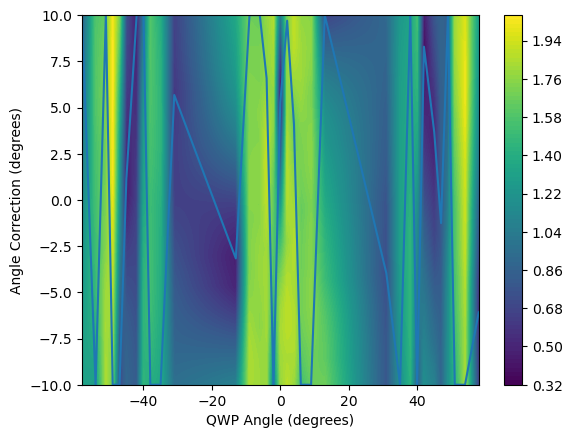

In [108]:
chi2_array=chi2.to_numpy()
plt.figure()
ax=plt.subplot(111)
plt.contourf(angles,diffs, chi2_array, levels=100)
plt.colorbar(ax=ax)
min_diff=np.argmin(chi2_array,axis=0)
plt.plot(angles,diffs[min_diff])
plt.xlabel('QWP Angle (degrees)')
plt.ylabel('Angle Correction (degrees)')

plt.show()